## 1. **Problem Definition and Data Collection**

- **Define the Objective:**  
  Determine what you want to achieve. For example, “Predict cyber-attack events” or “Detect anomalies in network logs.”
  
- **Collect Data:**  
  Gather your raw datasets from logs, databases, or external sources. The data might have issues like missing values, duplicates, or invalid entries.

---

## 2. **Initial Data Exploration (Exploratory Data Analysis - EDA)**

- **Load the Data:**  
  Use libraries such as `pandas` to load the dataset.

- **Inspect the Data:**  
  - Use `df.head()`, `df.info()`, and `df.describe()` to understand the data structure and statistics.
  - Check for missing values with `df.isnull().sum()` and duplicates with `df.duplicated().sum()`.

- **Visual Exploration:**  
  - **Histograms and Density Plots:** Show distribution of numeric features.
  - **Box Plots:** Visualize outliers.
  - **Scatter Plots:** Check relationships between variables.
  - **Correlation Heatmaps:** Identify relationships between variables.

*Example Code:*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("../Datasets/cybersecurity_logs.csv")

In [3]:
# Inspect the data
display(df.head())

,timestamp,source_ip,destination_ip,source_port,destination_port,protocol,action
0,2023-02-19 02:30:38,12.131.109.40,207.41.6.127,NaN,36427.0,UDP,ALLOW
1,2023-02-26 09:28:23,202.5.117.199,90.62.237.156,49415.0,41660.0,UDP,ALLOW
2,2023-02-23 14:20:10,220.56.77.179,232.186.194.71,55121.0,41575.0,UDP,DENY
3,2023-04-14 01:11:20,215.72.106.56,133.13.254.160,51852.0,49219.0,ICMP,DENY
4,2023-05-14 22:28:38,NaN,114.210.14.90,55205.0,43128.0,TCP,ALLOW


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15300 entries, 0 to 15299
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         15300 non-null  object 
 1   source_ip         15150 non-null  object 
 2   destination_ip    15157 non-null  object 
 3   source_port       15134 non-null  float64
 4   destination_port  15156 non-null  float64
 5   protocol          15151 non-null  object 
 6   action            15159 non-null  object 
dtypes: float64(2), object(5)
memory usage: 836.8+ KB


None

In [5]:
display(df.describe())

,source_port,destination_port
count,15134.000000,15156.000000
mean,32803.301374,32883.460676
std,18922.111958,19057.440609
min,-1.000000,-1.000000
25%,16572.250000,16405.000000
50%,32798.000000,32932.500000
75%,49244.500000,49336.750000
max,70000.000000,70000.000000


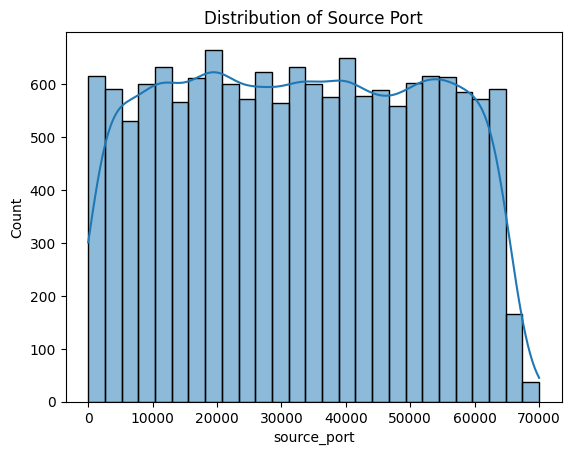

In [6]:
# Visualize distribution of a numeric column, e.g., source_port
sns.histplot(df['source_port'].dropna(), kde=True)
plt.title("Distribution of Source Port")
plt.show()

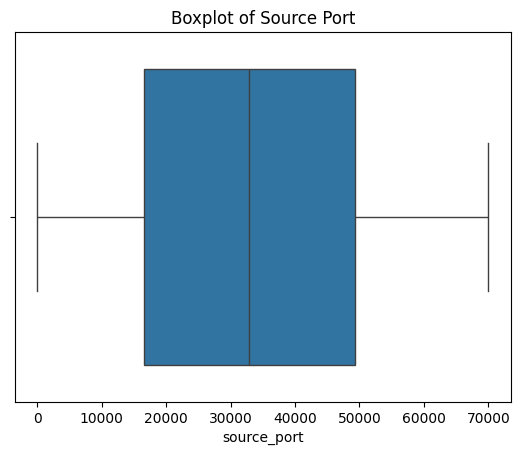

In [7]:
# Check for outliers with a boxplot
sns.boxplot(x=df['source_port'])
plt.title("Boxplot of Source Port")
plt.show()

## 3. **Data Cleaning**

### a. **Handling Missing Data**

- **Detection:**  
  Identify missing values using methods like `df.isnull().sum()`.

- **Treatment Options:**  
  - **Remove Rows/Columns:** If missing data is negligible.
  - **Imputation:** Replace missing values using statistical methods (mean, median) or more advanced techniques (e.g., KNN imputation).

In [8]:
df.isnull().sum()

timestamp             0
source_ip           150
destination_ip      143
source_port         166
destination_port    144
protocol            149
action              141
dtype: int64

In [9]:
# Simple imputation using median for numeric columns
df['source_port'] = df['source_port'].fillna(df['source_port'].median())

In [10]:
# For categorical features, use mode
df['protocol'] = df['protocol'].fillna(df['protocol'].mode()[0])

In [11]:
# --- Cleaning 'source_ip' ---
# Option 2: Fill missing with the mode (most frequent value)
if df['source_ip'].isnull().sum() > 0:
    source_ip_mode = df['source_ip'].mode()[0]
    df['source_ip'] = df['source_ip'].fillna(source_ip_mode)

In [12]:
# --- Cleaning 'destination_ip' ---
if df['destination_ip'].isnull().sum() > 0:
    destination_ip_mode = df['destination_ip'].mode()[0]
    df['destination_ip'] = df['destination_ip'].fillna(destination_ip_mode)

In [13]:
# --- Cleaning 'destination_port' ---
# Using the median can be a good option if the data is numeric.
if df['destination_port'].isnull().sum() > 0:
    destination_port_median = df['destination_port'].median()
    df['destination_port'] = df['destination_port'].fillna(destination_port_median)

In [14]:
# --- Cleaning 'action' ---
if df['action'].isnull().sum() > 0:
    action_mode = df['action'].mode()[0]
    df['action'] = df['action'].fillna(action_mode)

In [15]:
# Verify that there are no more missing values in these columns
df.isnull().sum()

timestamp           0
source_ip           0
destination_ip      0
source_port         0
destination_port    0
protocol            0
action              0
dtype: int64

### b. **Removing Duplicates**

- **Detection:**  
  Use `df.duplicated()` to find duplicate rows.

- **Removal:**  
  Remove duplicates with `df.drop_duplicates()`.

In [16]:
# Check and remove duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 300


In [17]:
df = df.drop_duplicates()

### c. **Filtering and Correcting Invalid Data**

- **Invalid Values:**  
  Identify invalid entries (e.g., negative port numbers, malformed IPs). You might create custom functions or use regular expressions to detect these.

- **Correction or Removal:**  
  Correct the invalid entries if possible or remove those rows.

In [18]:
import re

def is_valid_ip(ip):
    # Check if ip is a string and matches the IPv4 pattern
    pattern = r"^\d{1,3}(\.\d{1,3}){3}$"
    if isinstance(ip, str) and re.match(pattern, ip):
        # Check each octet is between 0 and 255
        parts = ip.split('.')
        return all(0 <= int(part) <= 255 for part in parts)
    return False

# Filter out invalid source IPs
df = df[df['source_ip'].apply(lambda ip: pd.isnull(ip) or is_valid_ip(ip))]

# Similarly, remove rows where port numbers are not in valid range
df = df[(df['source_port'].isnull()) | ((df['source_port'] > 0) & (df['source_port'] <= 65535))]
df = df[(df['destination_port'].isnull()) | ((df['destination_port'] > 0) & (df['destination_port'] <= 65535))]

## 4. **Preprocessing**

### a. **Feature Engineering and Transformation**

- **Encoding Categorical Variables:**  
  Use techniques like one-hot encoding or label encoding.

- **Scaling/Normalization:**  
  Standardize or normalize numerical data to improve the performance of many ML algorithms.

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Example: One-hot encode 'protocol'
df_encoded = pd.get_dummies(df, columns=['protocol'], dummy_na=True)

# Scale numeric columns (e.g., ports)
scaler = StandardScaler()
df_encoded[['source_port', 'destination_port']] = scaler.fit_transform(
    df_encoded[['source_port', 'destination_port']].fillna(0)  # fill missing with 0 or another strategy
)

### b. **Outlier Detection and Treatment Using ML**

- **Unsupervised Learning:**  
  Use clustering or anomaly detection algorithms (e.g., Isolation Forest, DBSCAN) to identify outliers.

In [20]:
from sklearn.ensemble import IsolationForest

# Select features to check for anomalies
features = df_encoded[['source_port', 'destination_port']].dropna()
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(features)

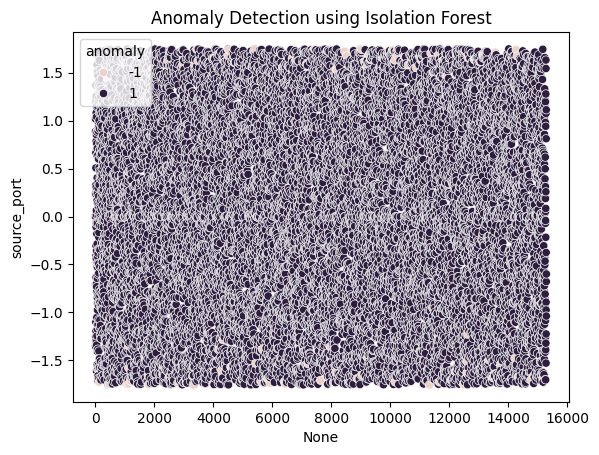

In [21]:
# Mark anomalies (-1 indicates anomaly)
features['anomaly'] = outliers
sns.scatterplot(x=features.index, y=features['source_port'], hue=features['anomaly'])
plt.title("Anomaly Detection using Isolation Forest")
plt.show()

In [22]:
# Optionally, remove anomalies
clean_features = features[features['anomaly'] == 1]

## 5. **Data Visualization**

### a. **Visualizing Cleaned Data**

- **Correlation Matrix:**  
  Use heatmaps to see the relationships between variables.

- **Pairplots:**  
  Visualize pairwise relationships in the dataset.


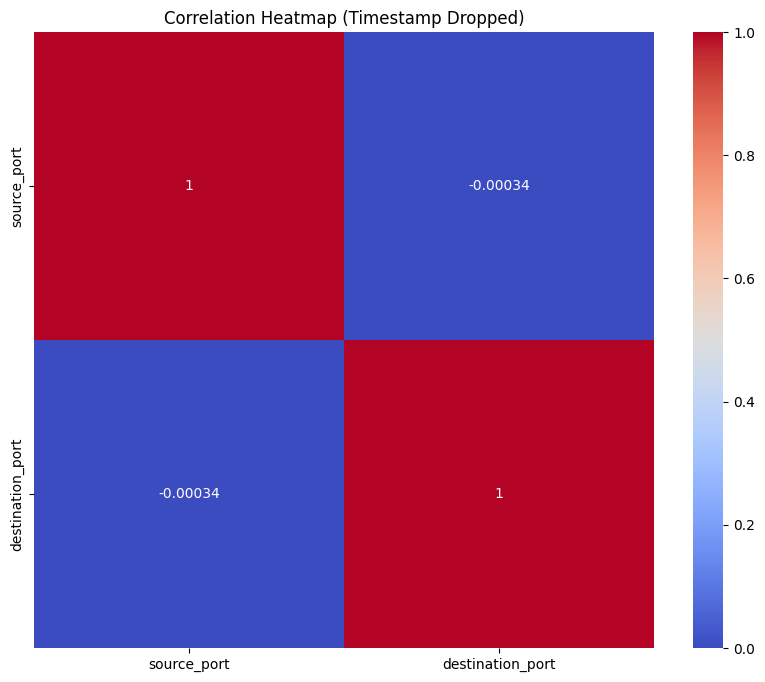

In [24]:
import numpy as np
# Drop the timestamp column
df = df.drop(columns=['timestamp'], errors='ignore')

# Optionally, select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Timestamp Dropped)")
plt.show()

### b. **Visualizing Preprocessing Results**

- **Before and After Cleaning:**  
  Plot distributions of key variables before and after cleaning to verify improvements.

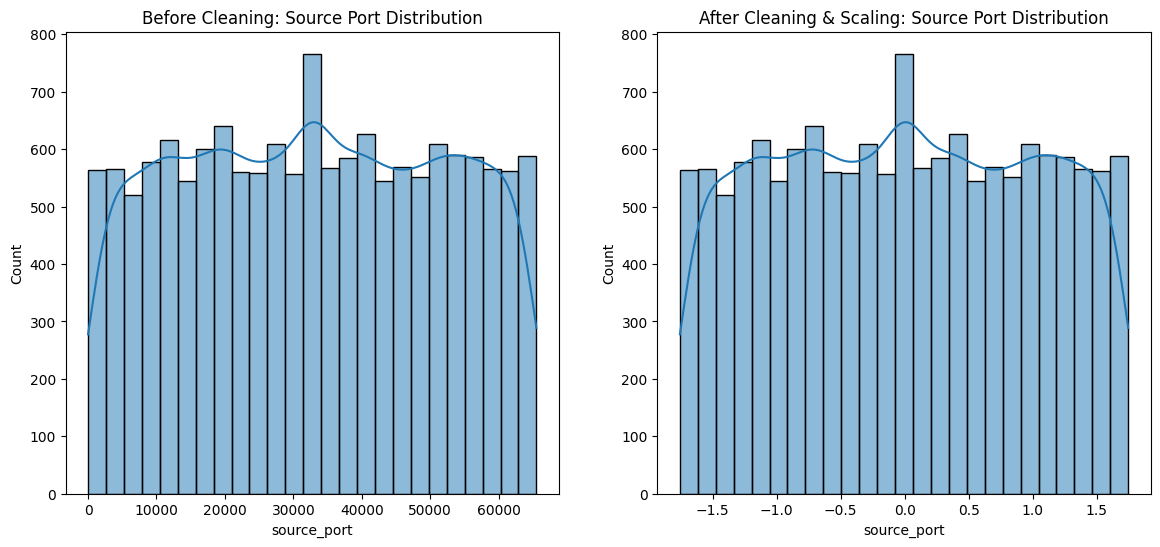

In [26]:
# Compare distribution before and after cleaning for source_port
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['source_port'].dropna(), kde=True)
plt.title("Before Cleaning: Source Port Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df_encoded['source_port'], kde=True)
plt.title("After Cleaning & Scaling: Source Port Distribution")

plt.show()